In [15]:
import pandas as pd
import os
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import unicodedata,string
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [16]:
data = pd.read_csv("inverted_index.csv")
data.index = data['Unnamed: 0']
data = data.drop(['Unnamed: 0'],axis=1)
data.index = data.index.rename("words")
data

,T1.txt,T10.txt,T2.txt,T3.txt,T4.txt,T5.txt,T6.txt,T7.txt,T8.txt,T9.txt
words,,,,,,,,,,
abandon,1,0,0,0,0,0,0,0,2,0
abbrevi,0,0,1,0,0,0,0,0,0,0
abdomen,0,0,1,0,0,0,0,0,0,0
abdomin,0,0,1,0,0,0,0,0,0,0
aberdeen,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
zo,0,0,0,1,0,0,0,0,0,0
zone,0,0,2,0,0,0,0,0,0,0
zoolog,0,0,0,0,0,0,0,0,0,5


In [17]:
def preprocess(data):
    # convert to lower case and remove numbers , punctuations , whitespaces
    
    data = data.lower()
    data = r e.sub(r'\d+','',data)
    data = re.sub(r'\n',' ',data)
    data = re.sub(r'[^A-Za-z]+',' ',data)
    data = data.translate(str.maketrans('','', string.punctuation))
    data = data.strip()
    
    
    # tokenization 
    
    # 1. stop words removal
    
    stop_words = set(stopwords.words('english'))   
    tokens = word_tokenize(data)
    result = [i for i in tokens if  i not in stop_words]
    result = [unicodedata.normalize('NFKD', i).encode('ascii', 'ignore').decode('utf-8', 'ignore') for i in result] 
    
    # 2. stemming
    
    stemmer= PorterStemmer()
    new_result = [stemmer.stem(i) for i in result]
    new_result = [i for i in new_result if  i not in stop_words]
    
    
    return new_result

In [18]:
def tf_idf(data):
    #normalise
    data = data.apply(lambda x : x/np.max(x),axis=0)
    
    #idf 
    idf_score = {}
    count = data.astype('bool').sum(axis=1)
    N = data.shape[1]
    
    for word in data.index:
            idf_score[word] = np.log10(N/count[word])
     
    #tf-idf
    data = data.multiply(idf_score,axis=0)
            
    return data,idf_score

In [21]:
def get_tf_idf_query(query_words,idf_score):
    query = [0 for i in range(data.shape[0])]
    query = pd.DataFrame(query,index = data.index ,columns=['query'])
    
    for i in query_words:
        if i in query.index:
            query.loc[i] = query_words.count(i)
    
    query = query.apply(lambda x : x/np.max(x),axis=0)
    query = query.multiply(idf_score,axis=0)
    
    return query

In [22]:
tf_idf_data , idf_score = tf_idf(data)
tf_idf_data

,T1.txt,T10.txt,T2.txt,T3.txt,T4.txt,T5.txt,T6.txt,T7.txt,T8.txt,T9.txt
words,,,,,,,,,,
abandon,0.006853,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.015707,0.000000
abbrevi,0.000000,0.0,0.012658,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
abdomen,0.000000,0.0,0.012658,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
abdomin,0.000000,0.0,0.012658,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
aberdeen,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.010989
...,...,...,...,...,...,...,...,...,...,...
zo,0.000000,0.0,0.000000,0.011765,0.0,0.0,0.0,0.0,0.000000,0.000000
zone,0.000000,0.0,0.025316,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
zoolog,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.054945


In [23]:
def get_rank(tf_idf_data , tf_idf_query):
    dist1 = np.sqrt(tf_idf_query.apply(np.square).sum()).values[0]
    query_docs = {}
    query_docs["query"] = {}
    
    if(dist1==0):
        return None
     
    for column in tf_idf_data:
        num = 0
        sum_of_squares = 0
        
        sum_of_squares = tf_idf_data[column].apply(np.square).sum()
        vec_product = tf_idf_data[column].multiply(tf_idf_query.values.reshape(tf_idf_query.shape[0])).sum()
        
        dist2 = np.sqrt(sum_of_squares)  
        cosine_similarity = vec_product / (dist1 * dist2)
        query_docs["query"][column] = cosine_similarity
        
    return query_docs

In [24]:
query  = input('enter query : ')
pquery = preprocess(query)
print(pquery)

enter query :  intelligence


['intellig']


In [25]:
tf_idf_query = get_tf_idf_query(pquery , idf_score)

In [28]:
rank = get_rank(tf_idf_data , tf_idf_query)

if(rank):
    rank = pd.DataFrame(rank).sort_values(by = "query" , ascending=False)
else:
    print('no query match found in any document')

In [29]:
rank.T

,T10.txt,T2.txt,T9.txt,T6.txt,T3.txt,T4.txt,T1.txt,T5.txt,T7.txt,T8.txt
query,0.128587,0.041869,0.028533,0.026315,0.01682,0.006898,0.0,0.0,0.0,0.0


In [30]:
for i in pquery:
    if i in data.index:
        print((data.loc[i]).sort_values(),"\n")

T1.txt      0
T5.txt      0
T7.txt      0
T8.txt      0
T4.txt      1
T6.txt      2
T3.txt      5
T9.txt      7
T2.txt     17
T10.txt    20
Name: intellig, dtype: int64 



In [31]:
def doc_similarity(tf_idf_docs):
    res = {}
    
    for col in tf_idf_docs:
        dist1 = np.sqrt(tf_idf_docs[col].apply(np.square).sum())
        res[col] = {}

        for column in tf_idf_docs:
            vec_product = 0
            sum_of_squares = 0

            sum_of_squares = tf_idf_docs[column].apply(np.square).sum()
            vec_product = tf_idf_docs[column].multiply(tf_idf_docs[col]).sum()
            
            dist2= np.sqrt(sum_of_squares)  
            
            cosine_similarity = vec_product / (dist1 * dist2)
            res[col][column] = cosine_similarity
    
    return pd.DataFrame(res)

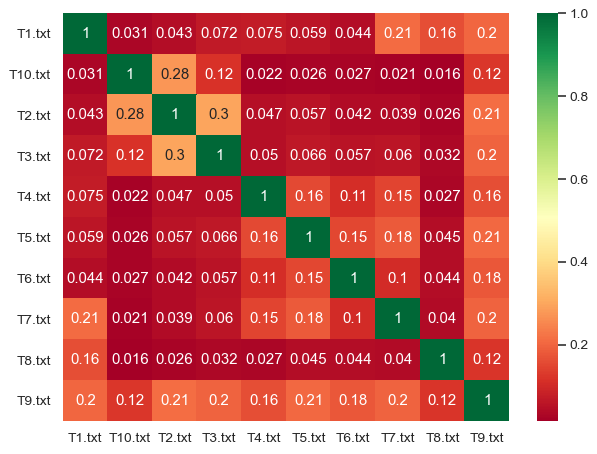

In [32]:
sns.set()

mat = doc_similarity(tf_idf_data)
features = mat.index

plt.figure(figsize=(8,6),dpi=90)
g = sns.heatmap(mat[features],annot=True,cmap="RdYlGn")
plt.show()